# Comparing Total Hydrostatic Masses Between Analyses

This notebook measures hydrostatic masses for the samples we are using to verify our method, then compares them to the measurements from literature. These mass measurements include both the baryonic content of the intra-cluster medium, and that of the dark matter halo. This implicitly tests how close our measured temperature and density profiles are to those measured by the work we compare them to

The LoCuSS and Lovisari samples both have hydrostatic mass measurements associated with them which we will compare to, but the SDSSRM-XCS sample does not (such measurements will be presented in an upcoming paper), and the XXL-100-GC sample data is generally too shallow for such measurements.

## Import Statements

In [23]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, Unit
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from copy import deepcopy

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 60
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.sourcetools.mass import inv_abel_dens_onion_temp
from xga.models import DoubleBetaProfile1D, SimpleVikhlininDensity1D, SimpleVikhlininTemperature1D
from xga.exceptions import ModelNotAssociatedError

## Defining useful functions

In [2]:
# This function is used for getting axis limits for the the one to one comparison plots later
def find_lims(x_dat, y_dat, buffer=0.1):
    # A buffer of some percent (default 10) is added to the max and min values to make the plot 
    #  more easily readable
    lom = 1 - buffer
    him = 1 + buffer
    
    # Check if either are all NaNs
    if np.isnan(x_dat).all():
        x_dat = y_dat.copy()
    if np.isnan(y_dat).all():
        y_dat = x_dat.copy()
    
    # Reading out the values without errors
    x_vals = x_dat[:, 0]
    y_vals = y_dat[:, 0]
    
    # Depending on whether the input data has + and - errors, or just a standard deviation, depends how
    #  we find maximum and minimum values
    if x_dat.shape[1] == 3:
        # In this case upper and lower errors are present
        lb = x_vals-x_dat[:, 1]
        # Make sure that we don't count any NaN values, and don't count any negative values
        #  The lower errors are subtracted from the measurements, and upper values added to them
        #  Then max and mins are found 
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 2])]
    elif x_dat.shape[1] == 2:
        # The behaviour is largely the same as above, but for symmetrical errors
        lb = x_vals-x_dat[:, 1]
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 1])]
    
    if y_dat.shape[1] == 3:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 2])]
    elif y_dat.shape[1] == 2:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 1])]
    
    # Then find the minimum and maximum values from the min and max x and y data, and multiply by the buffer
    lims = Quantity([lom*min([x_lims[0], y_lims[0]]), him*max([x_lims[1], y_lims[1]])])
    
    # Return the limits for the square like for like comparison plot
    return lims

## Reading colour configuration file

In [3]:
samp_colours = pd.read_csv("samp_plot_colours.csv")

lov_colour = samp_colours[samp_colours['samp_name'] == 'lovisari'].iloc[0]['samp_colour']
loc_colour = samp_colours[samp_colours['samp_name'] == 'locuss'].iloc[0]['samp_colour']

## Setting up cosmology

The LoCuSS and Lovisari analyses use the same concordance cosmology, but the XXL analysis of their bright cluster sample uses the WMAP9 results, and in case we wish to change anything for an individual sample later we define three separate cosmology objects to pass into our samples.

In [4]:
locuss_cosmo = LambdaCDM(70, 0.3, 0.7)
lovisari_cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading in Sample Files and Declaring XGA ClusterSamples

$\color{red}{\text{NEED TO MENTION/PUBLISH THE OBSIDS THAT WE EXCLUDE FROM USE DUE TO DATA PROBLEMS LIKE FLARING}}$

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$ - XGA centering on

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [5]:
locuss = pd.read_csv("sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [7]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=True, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|████████████████████▏                                   | 18/50 [03:05<05:50, 10.95s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|█████████████████████████▊                              | 23/50 [03:59<05:37, 12.50s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  54%|██████████████████████████████▏                         | 27/50 [04:23<03:14,  8.48s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source Abell1682 does 

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: Abell2219 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for Abell2219 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  89%|██████████████████████████████████████████████████▊      | 41/46 [05:55<01:06, 13.28s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0093031601, associated with source Abell2261
  warnings.warn("There are {0} alternative matches for observat

### Planck Selected with XMM follow-up - XGA centering on

The Lovisari et al. sample was selected from Planck-eSZ, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [6]:
lovisari = pd.read_csv("sample_files/lovisari_planck_clusters.csv")

In [8]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = lovisari['planck_ra'].values
dec = lovisari['planck_dec'].values
z = lovisari['z'].values
n = lovisari['name'].values
r500 = Quantity(lovisari['r500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the Lovisari sample
lovisari_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=lovisari_cosmo, load_fits=True, use_peak=True, 
                            clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  50%|███████████████████████████▌                           | 60/120 [09:25<07:11,  7.18s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.17-21.91 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0675470101/0675470101_mos2_G226.17-21.91_ra88.262_dec-21.062_ri0.0483332993719956_ro0.05437496179349506_grpTrue_mincnt5_ident72837747_6_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
Declaring BaseSource Sample:  51%|███████████████████████████▉                           | 61/120 [09:40<09:19,  9.48s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280201/0551280201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarni

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0105660101/0105660101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0105660101/0105660101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning:

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: G080.38-33.20 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G080.38-33.20 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  29%|████████████████▎                                       | 35/120 [05:18<09:04,  6.41s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: G093.91+34.90 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available da

Setting up Galaxy Clusters:  51%|████████████████████████████▍                           | 61/120 [08:24<09:02,  9.20s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280201/0551280201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280201/0551280201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarni

Setting up Galaxy Clusters:  70%|███████████████████████████████████████▏                | 84/120 [11:17<04:51,  8.09s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G266.03-21.25 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  73%|█████████████████████████████████████████               | 88/120 [11:46<03:43,  6.98s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0105262501 and is very close to the user supplied coordinates of G272.10-40.15. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/

## Running PSF Correction

In [10]:
rl_psf(locuss_srcs)
rl_psf(lovisari_srcs)

## Reading in literature data

###   $\color{red}{\text{Hydrostatic masses from literature}}$

In [50]:
lov_lit_ms = [lovisari[lovisari['name'] == n].iloc[0][['m500', 'm500-', 'm500+']].values*1e+14
               for n in lovisari_srcs.names]
lov_lit_ms = Quantity(lov_lit_ms, 'Msun')

loc_lit_ms = [locuss[locuss['name'] == n].iloc[0][['x_m500', 'x_m500_err']].values
               for n in locuss_srcs.names]
loc_lit_ms = Quantity(loc_lit_ms, 'Msun')

### Conversion Temperatures

In [15]:
loc_conv_txs = []
lov_conv_txs = []

for src in locuss_srcs:
    loc_conv_txs.append(locuss[locuss['name'] == src.name].iloc[0]['x_Tx500ce'])

for src in lovisari_srcs:
    lov_conv_txs.append(lovisari[lovisari['name'] == src.name].iloc[0]['Tx'])

loc_conv_txs = Quantity(loc_conv_txs, 'keV')
lov_conv_txs = Quantity(lov_conv_txs, 'keV')

## Hydrostatic Mass Comparison to Literature - Density from $S_B$ Profiles

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to 1.05$R_{500}$

In [16]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [18]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [24]:
demo_t_mod = SimpleVikhlininTemperature1D()
demo_t_mod.info()
demo_t_mod.par_priors

╒════════════════════════════════╤═════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                     │
╞════════════════════════════════╪═════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Temperature                                                     │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ keV                                                                 │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ r_cool, a_cool, t_min, t_zero, r_tran, c_power                      │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ kpc, , keV, keV, kpc

[{'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [-10.,  10.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 15.] keV>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 15.] keV>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [-10.,  10.]>, 'type': 'uniform'}]

In [26]:
loc_sb_dblbeta_simpvikh_105_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500*1.05, 'double_beta', 
                                                          'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                          temp_min_snr=30)

Running XSPEC Fits: 100%|█████████████████████████████████████████████████████████████████| 46/46 [09:05<00:00, 11.85s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:152: UserWarning: The requested annuli for RXCJ1212.3-1816 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
Generating products of type(s) spectrum: 100%|████████████████████████████████████████| 210/210 [1:37:02<00:00, 27.72s/it]
Generating products of type(s) annular spectrum set components: 100%|███████████████| 2591/2591 [3:02:19<00:00,  4.22s/it]
Running XSPEC Fits: 100%|███████████████████████████████████████████████████████████████| 540/540 [19:57<00:00,  2.22s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0963 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fi

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1229.14529149 1100.49414714 1434.2044592  1077.20861762 1205.54654386
 1195.1302909 ]


Fitting data, inverse Abel transforming, and measuring densities:   5%|▉                   | 2/41 [00:51<17:02, 26.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [774.42196213 665.44705779 746.11352968 681.37584153 685.10009775
 828.1675351 ]


Fitting data, inverse Abel transforming, and measuring densities:   7%|█▍                  | 3/41 [01:17<16:22, 25.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1699.98765624  646.40236017 1918.27820976 1387.04695041 1572.68120703
 1809.8705095 ]


Fitting data, inverse Abel transforming, and measuring densities:  10%|█▉                  | 4/41 [01:41<15:34, 25.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1500.92908433 1472.6148793  1865.17866583 1634.31679224 1638.29708579
 1834.95739728]


Fitting data, inverse Abel transforming, and measuring densities:  12%|██▍                 | 5/41 [02:05<14:50, 24.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [400.29722854 848.42829828 226.49995004 220.07103945 501.52264934
 535.918696  ]


Fitting data, inverse Abel transforming, and measuring densities:  15%|██▉                 | 6/41 [02:30<14:24, 24.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1086.78668289  933.62483145 1393.53970219  988.70529035 1498.06920996
 1428.21232594]


Fitting data, inverse Abel transforming, and measuring densities:  20%|███▉                | 8/41 [03:22<13:55, 25.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 275.67461288  240.13298236 1816.91650966 1698.29479213 1807.75307692
 1805.81781215]


Fitting data, inverse Abel transforming, and measuring densities:  32%|██████             | 13/41 [05:35<12:14, 26.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [878.11184366 163.799635   855.31244206 684.88924786 832.42565843
 851.13661748]


Fitting data, inverse Abel transforming, and measuring densities:  34%|██████▍            | 14/41 [06:02<11:52, 26.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1065.78406437 1057.58119807  970.29089328  835.70485822  915.86931289
 1062.79013263]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██████▉            | 15/41 [06:27<11:16, 26.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [159.0592     448.76189408 248.16303007 203.0743091  294.47503272
 357.13292933]


Fitting data, inverse Abel transforming, and measuring densities:  51%|█████████▋         | 21/41 [09:04<08:30, 25.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [183.85273046 569.07435164 304.87873843 804.91964279 784.84250988
 616.01056552]


Fitting data, inverse Abel transforming, and measuring densities:  56%|██████████▋        | 23/41 [09:58<07:50, 26.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [145.54357295 410.57231546 100.79500788 138.95675495 176.88377555
 251.31035006]


Fitting data, inverse Abel transforming, and measuring densities:  59%|███████████        | 24/41 [10:23<07:20, 25.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2004.56599566 1313.47958286 2335.84275693 1999.36416183 2195.14693363
 2336.56860684]


Fitting data, inverse Abel transforming, and measuring densities:  71%|█████████████▍     | 29/41 [12:40<05:18, 26.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 625.33450923 1370.61242589 1852.37515868 2199.49654914 2257.30949464
 2066.78582232]


Fitting data, inverse Abel transforming, and measuring densities:  73%|█████████████▉     | 30/41 [13:04<04:45, 25.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1082.58546147  704.00347939 1376.5534789  1308.18992686 1374.11344113
 1451.78868018]


Fitting data, inverse Abel transforming, and measuring densities:  83%|███████████████▊   | 34/41 [14:56<03:11, 27.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [718.1483636  741.23957528 798.07725339 650.80938357 772.70054067
 808.41530569]


Fitting data, inverse Abel transforming, and measuring densities:  93%|█████████████████▌ | 38/41 [16:46<01:21, 27.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1334.64431143  693.51305064 1257.99124804 1009.1704986  1137.15980445
 1260.75062611]


Fitting data, inverse Abel transforming, and measuring densities:  95%|██████████████████ | 39/41 [17:13<00:53, 26.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [407.38021617 417.38695752 450.25177498 313.64427925 408.24227703
 512.2851286 ]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████████████████| 41/41 [18:03<00:00, 26.42s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 979.15733576  244.53660969 1976.01397204 1753.05637497 1414.9678549
 1915.96872798]


Generating Abell2697 hydrostatic mass profile:   0%|                                               | 0/46 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [567.1133016  822.23760149 562.22116335 464.28934121 911.91309171
 406.83524979]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 112.62816036  164.03784508 1300.17448828  110.86765916  110.27143709
  565.53697013]


Generating Abell0068 hydrostatic mass profile:   2%|▊                                      | 1/46 [00:49<37:25, 49.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [301.88963025 477.75982239 386.94530657 438.98725263 314.31978327
 322.37969616]


Generating Abell2813 hydrostatic mass profile:   4%|█▋                                     | 2/46 [01:39<36:35, 49.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [628.1654569  809.68872461 641.87711542 777.9772017  904.5102499
 464.18701743]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [198.33568831 339.2362879  582.0418806  157.49398188 130.83359708
 516.36129738]


Generating Abell0115S hydrostatic mass profile:   7%|██▍                                   | 3/46 [02:29<35:37, 49.72s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1269.07210821 1720.52584687 2440.86683826 1509.24977213  583.62211925
 1503.77843876]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 216.61464814  218.3541352  1493.88546074  261.84745373  230.81344076
  283.71737725]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell141 hydrostatic mass profile:   9%|███▍                                    | 4/46 [03:18<34:32, 49.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [770.5768317  640.67409535 637.90986532 700.12870846 527.73651003
 596.81632278]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [418.33260742 417.24907459 427.91133001 599.56501932 370.87311282
 520.87887552]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|███▌                             | 5/46 [04:06<33:27, 48.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1281.4723147  1446.52166738 1393.8731075  1473.94681327 2154.43383618
 1620.66060174]


Generating Abell0209 hydrostatic mass profile:  13%|█████                                  | 6/46 [04:51<31:46, 47.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 123.27812719  121.77752594 1085.53340786  197.99987777  172.18183634
  132.50103824]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [615.68999254 887.05925208 668.77851025 516.38991462 497.61777579
 510.15878694]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 810.3126211  1006.11956817 1192.71545334  490.18950031  826.20743311
 1047.10185018]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0267 hydrostatic mass profile:  15%|█████▉                                 | 7/46 [05:43<31:54, 49.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [333.45575025 868.87699614 495.02054145 535.34718636 392.83124713
 350.12300367]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 104.97944888  103.51498585 1058.73297278  107.20836752  118.98996847
  100.34559668]


Generating Abell0291 hydrostatic mass profile:  17%|██████▊                                | 8/46 [06:32<31:04, 49.07s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [579.74401899 666.48220885 249.66064897 505.74993782 360.15814483
 338.90027826]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 88.86562287  92.77132765 744.68959442  86.29210982  86.44225057
  89.87285067]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0383 hydrostatic mass profile:  20%|███████▋                               | 9/46 [07:24<30:47, 49.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1458.59207319 1640.95112913 1356.78816024 1228.57497744 2016.46332043
 1392.1202297 ]


Generating Abell0521 hydrostatic mass profile:  22%|████████▎                             | 10/46 [08:14<30:04, 50.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1105.33182931 1080.51437031  757.67929506 1194.19720228  635.04159047
  490.31416787]


Generating Abell0586 hydrostatic mass profile:  24%|█████████                             | 11/46 [09:04<29:09, 49.98s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [504.18243852 708.28179266 483.64210262 573.74564421 487.30422511
 367.53719489]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0611 hydrostatic mass profile:  26%|█████████▉                            | 12/46 [09:54<28:22, 50.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 367.20904717 1184.93339418  388.78242005  338.97173692  347.97180286
  362.06834492]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [319.60458918 408.91457512 726.79793402 262.48369654 182.83739475
 459.44343009]


Generating ZwCl0857.9+2107 hydrostatic mass profile:  30%|█████████▋                      | 14/46 [10:43<26:27, 49.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 412.72060485 1441.56189812  760.10310555  726.22904953  401.74894506
  396.99977257]


Generating Abell0750 hydrostatic mass profile:  33%|████████████▍                         | 15/46 [11:30<19:22, 37.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [102.69472376 114.84551217 695.19350072 117.97012132 121.07318106
 131.62658457]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 983.67558276 1224.2819758  1201.77185115 1175.41165145  785.29672287
  987.38229512]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0781 hydrostatic mass profile:  37%|██████████████                        | 17/46 [12:19<19:27, 40.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [970.927525   868.61705408 298.49909469 715.02991959 295.28052691
 388.15400206]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1061.40731167  855.89230064  889.90343609  566.7368844   441.57927329
  503.33502912]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [104.72419312 148.78557002 888.87485087 104.69937598 116.53076619
 178.35511401]


Generating Abell0901 hydrostatic mass profile:  39%|██████████████▊                       | 18/46 [13:06<15:37, 33.49s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1246.16942689 1342.27257972  801.59988675  788.08846624 1917.07821065
 1155.57346944]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.16924606  86.74695989 707.99746917 102.28462049 105.10011796
  84.84045493]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0907 hydrostatic mass profile:  41%|███████████████▋                      | 19/46 [13:57<16:50, 37.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [505.38247116 550.15290495 251.56941362 403.70347144 282.79677232
 265.69936334]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  46%|██████████████▌                 | 21/46 [14:51<17:15, 41.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1325.51631177 1536.79171315 1477.07472372 1549.29736285 1127.72422333
  808.58219796]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.52047365  88.1376582  886.46036704  79.35946793 145.05574682
  60.00437741]


Generating RXCJ1212.3-1816 hydrostatic mass profile:  50%|████████████████                | 23/46 [15:40<13:13, 34.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [660.49129924 873.57374486 677.99363357 717.49594489 701.18405534
 744.82002707]


Generating ZwCl1231.4+1007 hydrostatic mass profile:  52%|████████████████▋               | 24/46 [16:24<10:56, 29.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 947.34091755  693.42436913  676.30653685 1015.3318928   403.09311843
  744.11688657]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 747.38400436  797.76705426  660.01174282 1007.65011631  921.7193512
  517.01994332]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 327.44709736  783.18475777 1171.68756968  247.17638004  185.22412647
  911.09542473]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1689 hydrostatic mass profile:  54%|████████████████████▋                 | 25/46 [17:14<11:53, 33.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 910.32549114 1048.76846368 1223.43819075 1323.65251025  769.68935715
  999.36476059]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.09435953  81.68835781 580.18339307  90.08733145  89.59344442
  78.29428329]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1758N hydrostatic mass profile:  57%|████████████████████▉                | 26/46 [18:09<12:57, 38.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1012.8473945  1020.9216412  1063.39693695 1089.74823672  664.69162616
  956.67063261]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1868.98194458 2035.14397942 1958.30849841 1971.31222757 1069.02958135
 2034.55827176]


Generating Abell1763 hydrostatic mass profile:  59%|██████████████████████▎               | 27/46 [18:59<13:11, 41.64s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [317.13256638 659.65696242 504.44096458 414.41158961 318.8996841
 397.2666281 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [186.52248614 175.94511086 718.463923   341.70381355 395.08742751
 203.191875  ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1835 hydrostatic mass profile:  61%|███████████████████████▏              | 28/46 [19:50<13:13, 44.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1584.83867    1278.02598612 1523.25163121 1677.25750785  684.7397223
 1238.53455913]


Generating Abell1914 hydrostatic mass profile:  63%|███████████████████████▉              | 29/46 [20:44<13:17, 46.91s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [455.83955571 542.20018831 520.49005345 560.24129114 489.92006779
 389.74517263]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 93.75143991  95.62412169 438.49170815  88.3046599   84.51631137
  96.82641406]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating ZwCl1454.8+2233 hydrostatic mass profile:  65%|████████████████████▊           | 30/46 [21:38<13:01, 48.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1006.61269726 1190.4734581   464.8373566   784.57655389  362.28289502
  351.73757168]


Generating Abell2009 hydrostatic mass profile:  67%|█████████████████████████▌            | 31/46 [22:27<12:13, 48.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  99.21679447   93.21008315 1212.91865996  104.73780153  116.82433156
   90.71059295]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [455.19128471 627.03392545 509.6213491  337.12652852 218.29885306
 233.79496648]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [142.64775801 303.73948085 606.05477417 111.11460508 146.10578614
 394.55865546]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating ZwCl1459.4+4240 hydrostatic mass profile:  70%|██████████████████████▎         | 32/46 [23:23<11:52, 50.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [740.19458382 896.02432952 569.57267585 788.78886665 577.87900025
 539.42568209]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  72%|██████████████████████▉         | 33/46 [24:12<10:55, 50.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [392.47279162 547.31288255 316.35484994 327.55590171 473.78777153
 382.44606372]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [518.52109798 563.76905632 295.10153529 416.6435194  224.27940709
 228.15489261]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  79.76652336   79.85067413 1211.88922726   84.96892575   98.49498485
   60.84709344]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell2111 hydrostatic mass profile:  74%|████████████████████████████          | 34/46 [25:07<10:21, 51.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [362.87136748 449.5230545  416.16337586 364.72247482 335.17935023
 318.37057533]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [111.27708263 124.81874274 433.88006505 105.80514683  93.78599599
 134.33478376]


Generating Abell2204 hydrostatic mass profile:  76%|████████████████████████████▉         | 35/46 [25:58<09:27, 51.56s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [372.96364414 450.53096189 169.28089899 386.57201583 163.09390769
 160.35278459]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|██████████████████████████▌      | 37/46 [26:58<08:05, 53.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [576.96940617 646.76821766 201.20669915 561.28210047 249.5460558
 296.70771259]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 82.94850713  81.27909556 674.91153433  79.6878515   76.25331038
  65.94835005]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell2261 hydrostatic mass profile:  83%|███████████████████████████████▍      | 38/46 [27:54<05:35, 41.92s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:810: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator h

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [694.59103417 994.75949087 720.33175607 662.93095763 589.46425068
 627.91542199]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 84.79518459  88.1207048  548.33066065  79.46700639  84.38160565
  90.23217604]


Generating RXCJ2102.1-2431 hydrostatic mass profile:  85%|███████████████████████████▏    | 39/46 [28:45<05:10, 44.39s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1283.57600998 1557.72591091 1689.15894139 1351.96258824 2335.90857698
 1677.73696983]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 77.12539256  81.64165903 678.52453769  86.42911592  87.96925991
  83.08453341]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|████████████████████████████▋    | 40/46 [29:36<04:36, 46.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [614.43265943 991.29383973 980.51126552 692.99860457 467.69771938
 501.35846518]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 78.36319491  80.89359703 433.89616571  79.01066175  83.79408514
  87.6692705 ]


Generating Abell2390 hydrostatic mass profile:  89%|█████████████████████████████████▊    | 41/46 [30:27<03:57, 47.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.99651791  87.90874527 792.17286459  79.6377599   81.27776413
  87.48022075]


Generating Abell2537 hydrostatic mass profile:  91%|██████████████████████████████████▋   | 42/46 [31:23<03:18, 49.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [429.55400704 571.64791155 420.54666679 431.68262927 448.98504708
 358.35620876]


Generating Abell2552 hydrostatic mass profile:  93%|███████████████████████████████████▌  | 43/46 [32:11<02:27, 49.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 246.00974857  703.66361839 1613.07400609  176.15362549  130.38861514
 1069.14900191]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [487.88368142 839.56614177 410.92754599 547.18217114 771.28835684
 466.51002653]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [133.72127814 213.09248203 469.59284984 109.19569227 138.8340162
 250.37321635]


Generating Abell2631 hydrostatic mass profile:  96%|████████████████████████████████████▎ | 44/46 [33:01<01:39, 49.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [309.08403475 544.97267215 430.83689959 465.93205172 399.78986831
 385.17455942]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 951.60763441 1641.61677995 1021.73666611  882.53485986 1226.19794497
 1516.60353953]


Generating Abell2645 hydrostatic mass profile:  98%|█████████████████████████████████████▏| 45/46 [33:52<00:49, 49.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [538.7204532  680.54843825 501.85528042 662.56080272 443.78359452
 503.80976796]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [106.73791571 114.48968649 609.88127849 107.36471136 115.74461835
 152.95543262]


Complete: 100%|███████████████████████████████████████████████████████████████████████████| 46/46 [34:40<00:00, 45.24s/it]


In [45]:
lov_sb_dblbeta_simpvikh_105_mp = inv_abel_dens_onion_temp(lovisari_srcs, lovisari_srcs.r500*1.05, 'double_beta', 
                                                          'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                          temp_min_snr=30)

Running XSPEC Fits: 100%|███████████████████████████████████████████████████████████████████| 6/6 [02:59<00:00, 29.86s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:51: UserWarning: The global temperature fit for G042.82+56.61 has failed, and as such we're very unlikely to be able to measure a mass and we're not even going to try.
  warn("The global temperature fit for {} has failed, and as such we're very unlikely to be able to measure "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:51: UserWarning: The global temperature fit for G171.94-40.65 has failed, and as such we're very unlikely to be able to measure a mass and we're not even going to try.
  warn("The global temperature fit for {} has failed, and as such we're very unlikely to be able to measure "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:51: UserWarning: The global temperature fit for G229.94+15.29 has failed, and as such we're very unlikely to be able to measur

Fitting data, inverse Abel transforming, and measuring densities:   1%|▏                   | 1/94 [00:28<43:30, 28.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [217.19070386 518.07219231 934.07516759 214.81884161 202.92621311
 184.45450267]


Fitting data, inverse Abel transforming, and measuring densities:   2%|▍                   | 2/94 [00:56<42:55, 28.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1995.04816904  368.68929782 2458.62411798 2447.71261685 2384.39790309
 2424.0961334 ]


Fitting data, inverse Abel transforming, and measuring densities:   3%|▋                   | 3/94 [01:24<42:40, 28.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [749.23917651 718.38733963 633.06071128 624.18159842 630.12846344
 709.74529844]


Fitting data, inverse Abel transforming, and measuring densities:   5%|█                   | 5/94 [02:19<40:50, 27.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [781.23526427 936.49905258 464.52731377 916.96970291 850.41081102
 589.53068077]


Fitting data, inverse Abel transforming, and measuring densities:   9%|█▋                  | 8/94 [03:41<39:04, 27.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [570.91696153 576.57065888 747.10367721 560.78142975 548.10451221
 778.19880153]


Fitting data, inverse Abel transforming, and measuring densities:  11%|██                 | 10/94 [04:33<37:39, 26.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [676.39665613 652.61533851 648.71850782 508.95137779 595.35600811
 790.30461814]


Fitting data, inverse Abel transforming, and measuring densities:  15%|██▊                | 14/94 [06:35<39:06, 29.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [669.37989398 692.56310372 758.66015341 589.65321215 712.73207198
 762.47765141]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [229.57045698 533.81305832 860.96325434 219.698335   206.53464905
 187.64863726]


Fitting data, inverse Abel transforming, and measuring densities:  17%|███▏               | 16/94 [07:29<36:03, 27.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [156.11722313 568.10770193 214.18549547 439.5094514  517.95710523
 613.39598574]


Fitting data, inverse Abel transforming, and measuring densities:  21%|████               | 20/94 [09:27<35:58, 29.17s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G071.61+29.79's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  22%|████▏              | 21/94 [09:52<33:52, 27.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [781.24937973 793.59056155 398.348085   789.85277438 816.56313659
 758.3515078 ]


Fitting data, inverse Abel transforming, and measuring densities:  27%|█████              | 25/94 [11:49<32:55, 28.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 944.35658236  677.81698986  974.22588737  763.19532319  873.75454062
 1089.41554037]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█████▎             | 26/94 [12:13<31:01, 27.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [684.61270568 546.6234798  754.38414488 707.72368477 767.36148773
 784.9809083 ]


Fitting data, inverse Abel transforming, and measuring densities:  29%|█████▍             | 27/94 [12:40<30:12, 27.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [457.62065862 304.61228226 377.44960567 567.4225668  536.03730136
 566.28237678]


Fitting data, inverse Abel transforming, and measuring densities:  31%|█████▊             | 29/94 [13:32<28:41, 26.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1776.30183037 1313.32282363 2252.23607003 1842.4336403  2063.33731642
 2245.27259995]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [130.79157479 417.4762882  146.5406285  152.43279132 190.36742906
 229.1551066 ]


Fitting data, inverse Abel transforming, and measuring densities:  32%|██████             | 30/94 [14:00<28:39, 26.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 432.99887743 1228.13250833 1234.33949672  473.73663103  976.23693447
 1303.51464926]


Fitting data, inverse Abel transforming, and measuring densities:  34%|██████▍            | 32/94 [14:48<26:21, 25.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1647.85124235  653.28865955 1547.79517904 1221.1021433  1403.63009678
 1708.51653276]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██████▋            | 33/94 [15:13<25:47, 25.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [129.90955926 325.26642313 176.77656475 362.79771327 425.55136997
 465.39474923]


Fitting data, inverse Abel transforming, and measuring densities:  36%|██████▊            | 34/94 [15:37<24:51, 24.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [319.55821669 972.60111713 981.67770006 547.73513362 623.85639134
 815.83975071]


Fitting data, inverse Abel transforming, and measuring densities:  37%|███████            | 35/94 [16:01<24:25, 24.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [292.56497476 355.13488778 775.80599151 596.83592241 628.37404341
 646.2617769 ]


Fitting data, inverse Abel transforming, and measuring densities:  38%|███████▎           | 36/94 [16:23<23:12, 24.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [180.99562636 393.19874648 674.32708676 242.10697479 214.25216136
 237.57370695]


Fitting data, inverse Abel transforming, and measuring densities:  39%|███████▍           | 37/94 [16:47<22:47, 24.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 827.35758063 1134.9124126   889.91017396  909.56305248 1041.92820144
 1332.78955003]


Fitting data, inverse Abel transforming, and measuring densities:  43%|████████           | 40/94 [18:07<23:06, 25.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 628.64401258  744.58977334  277.07246591 1153.75253847 1090.00524106
  536.8326132 ]


Fitting data, inverse Abel transforming, and measuring densities:  44%|████████▎          | 41/94 [18:30<22:01, 24.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [421.88172331 680.20418029 508.28866913 805.55376152 907.18353856
 913.58097539]


Fitting data, inverse Abel transforming, and measuring densities:  45%|████████▍          | 42/94 [18:55<21:30, 24.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [339.49948686 734.2575627  804.48654521 539.27828061 682.17645606
 942.27510918]


Fitting data, inverse Abel transforming, and measuring densities:  46%|████████▋          | 43/94 [19:20<21:13, 24.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [152.54088875 352.677951   372.49169193 297.14626157 335.56058388
 407.37079395]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 550.6556247  1251.27724351 1889.56647731 1585.00668888 1690.27648311
 1583.51969634]


Fitting data, inverse Abel transforming, and measuring densities:  49%|█████████▎         | 46/94 [20:36<20:08, 25.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 839.86324415 1112.0433559  1611.36223974 1171.05577953 1302.31876916
  947.27781779]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 216.19520852  926.24738859 1192.91602129  890.48045454 1020.12691098
 1068.9939025 ]


Fitting data, inverse Abel transforming, and measuring densities:  52%|█████████▉         | 49/94 [22:00<19:55, 26.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 605.52947439  681.57643104 1957.52547134 1838.30539536 1843.11763174
 1889.61085323]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [366.1047442  639.3966937  613.99647266 427.29331568 410.54583446
 401.59181683]


Fitting data, inverse Abel transforming, and measuring densities:  53%|██████████         | 50/94 [22:26<19:20, 26.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1496.55289232  750.64514878 1471.16636973 1224.93574079 1346.13534791
 1456.59546469]


Fitting data, inverse Abel transforming, and measuring densities:  55%|██████████▌        | 52/94 [23:18<18:10, 25.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1021.14740877  571.35353799 1583.84333152 1518.70128768 1474.3102913
 1400.03395926]


Fitting data, inverse Abel transforming, and measuring densities:  56%|██████████▋        | 53/94 [23:47<18:30, 27.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1082.17350406 1243.73196943 1930.81501697 1909.31081906 1802.5002748
 1672.18531939]


Fitting data, inverse Abel transforming, and measuring densities:  59%|███████████        | 55/94 [24:42<17:36, 27.09s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G244.69+32.49's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  60%|███████████▎       | 56/94 [25:07<16:46, 26.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 729.30156063  253.17179952 1629.55859393 1321.20867196 1073.78443318
 1513.31998456]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1113.24360799 1998.60600913 1810.37855862 1993.89640674 1812.95134531
 1623.24700598]


Fitting data, inverse Abel transforming, and measuring densities:  62%|███████████▋       | 58/94 [25:53<14:47, 24.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 575.63956339 1283.38615588  521.16173033  747.53357202 1072.83949675
  744.98666107]


Fitting data, inverse Abel transforming, and measuring densities:  65%|████████████▎      | 61/94 [27:22<14:57, 27.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 602.20275589  985.86914809 1912.96609074 1782.81365909 1802.32861346
 1427.07448723]


Fitting data, inverse Abel transforming, and measuring densities:  73%|█████████████▉     | 69/94 [30:55<10:45, 25.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [273.71191272 328.14338968 341.93166019 355.39167346 396.42655368
 415.66747624]


Fitting data, inverse Abel transforming, and measuring densities:  77%|██████████████▌    | 72/94 [32:12<09:19, 25.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [605.54111287 559.95882104 658.78231478 482.73215963 537.9870805
 732.36040151]


Fitting data, inverse Abel transforming, and measuring densities:  78%|██████████████▊    | 73/94 [32:35<08:36, 24.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 973.57647516 1104.08922563 1324.43007633 1030.53902635 1249.23244654
 1468.32474251]


Fitting data, inverse Abel transforming, and measuring densities:  79%|██████████████▉    | 74/94 [33:01<08:19, 24.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [730.07452223 289.99030731 637.48340812 482.46024384 520.97082941
 680.20751479]


Fitting data, inverse Abel transforming, and measuring densities:  80%|███████████████▏   | 75/94 [33:24<07:46, 24.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [594.10713169 477.6386528  422.63881663 751.12086118 724.91333178
 744.54182541]


Fitting data, inverse Abel transforming, and measuring densities:  81%|███████████████▎   | 76/94 [33:49<07:24, 24.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [586.39914287 432.45773419 506.57161225 486.1438478  530.36328805
 643.58209517]


Fitting data, inverse Abel transforming, and measuring densities:  82%|███████████████▌   | 77/94 [34:14<06:59, 24.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [687.02282363 652.36751155 612.47396541 378.19694579 417.95611854
 600.25877663]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [778.57186677 526.19311836 766.36362734 569.53192943 660.08757136
 775.37189392]


Fitting data, inverse Abel transforming, and measuring densities:  84%|███████████████▉   | 79/94 [35:10<06:32, 26.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [792.93693162 854.99772828 387.54407111 735.56428524 727.1883284
 837.32828309]


Fitting data, inverse Abel transforming, and measuring densities:  85%|████████████████▏  | 80/94 [35:35<06:00, 25.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [398.61189657 410.91847363 479.14090046 382.88080878 417.0653487
 507.40280687]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G304.67-31.66's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  86%|████████████████▎  | 81/94 [35:57<05:18, 24.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 464.60796656 1345.33930639  837.31541481  489.24229758  622.78691274
 1172.79881785]


Fitting data, inverse Abel transforming, and measuring densities:  88%|████████████████▊  | 83/94 [36:56<05:04, 27.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [155.67367609 430.5362273  174.77148017 149.30476076 157.67129169
 177.84357272]


Fitting data, inverse Abel transforming, and measuring densities:  95%|█████████████████▉ | 89/94 [39:57<02:31, 30.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 566.59625659 1335.24648462 1026.77781661 1418.94361945 1466.10135026
 1481.74857198]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████████████████▌| 92/94 [41:18<00:55, 27.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1163.55442075 1188.42747867 2269.76162312 1936.92756489 1800.14206736
 2252.79881199]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████████████████| 94/94 [42:07<00:00, 26.89s/it]
Generating G002.74-56.18 hydrostatic mass profile:   1%|▎                               | 1/119 [00:00<00:00, 3028.38it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.65360074  92.89744544 469.50692313  82.10616403  90.37983023
 104.10016131]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G003.90-59.41 hydrostatic mass profile:   2%|▌                                 | 2/119 [00:32<32:00, 16.41s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1593.9820942  1880.02437669 1068.37522611 1740.41935587 1033.76444621
 1421.90711317]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:209: UserWarning: A mass of less than zero was measured by a hydrostatic mass profile, this is not physical and the profile is not valid.
  warn("A mass of less than zero was measured by a hydrostatic mass profile, this is not physical"
Generating G006.70-35.54 hydrostatic mass profile:   3%|▊                                 | 3/119 [01:01<41:46, 21.61s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [109.51866234 111.41679757 631.02782589 108.6466184  123.91629553
 147.69812398]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G008.44-56.35 hydrostatic mass profile:   4%|█▍                                | 5/119 [01:36<50:43, 26.69s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 90.62403247  98.5169881  522.50813628  84.3892458   84.32198341
 102.33503077]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G008.93-81.23 hydrostatic mass profile:   5%|█▋                                | 6/119 [02:08<39:53, 21.18s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G021.09+33.25 hydrostatic mass profile:   6%|██                                | 7/119 [02:39<44:00, 23.57s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered b

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 77.99564059  82.41040074 588.14697303  82.61117231  84.15926928
  70.39833099]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G036.72+14.92 hydrostatic mass profile:   7%|██▎                               | 8/119 [03:12<48:42, 26.33s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G039.85-39.98 hydrostatic mass profile:   8%|██▌                               | 9/119 [03:45<51:41, 28.20s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1801.55100835 2123.95547059 1153.59228177 1095.77828558 1990.77886881
 1943.46596025]


Generating G046.08+27.18 hydrostatic mass profile:   9%|███                              | 11/119 [04:19<53:50, 29.92s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1308.96555869 1880.93978178 1863.31635848 1851.42765574 1123.70696897
 2003.1042164 ]


Generating G049.20+30.86 hydrostatic mass profile:  11%|███▌                             | 13/119 [04:47<40:06, 22.70s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 71.74249345  79.63721732 704.66459676  78.61811801  82.89592648
  72.84088973]


Generating G049.33+44.38 hydrostatic mass profile:  12%|███▉                             | 14/119 [05:20<35:19, 20.19s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 104.21880859  116.48911267 1011.02745562   99.40224539  122.78006639
  123.42472223]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G049.66-49.50 hydrostatic mass profile:  13%|████▏                            | 15/119 [05:53<40:11, 23.19s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [185.79650819 255.23185612 490.28852156 140.26903501 189.75840462
 293.36765115]


Generating G053.52+59.54 hydrostatic mass profile:  13%|████▍                            | 16/119 [06:30<45:27, 26.48s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G055.60+31.86 hydrostatic mass profile:  14%|████▋                            | 17/119 [07:07<49:19, 29.02s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G056.81+36.31 hydrostatic mass profile:  16%|█████▎                           | 19/119 [07:38<49:08, 29.49s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/produ

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [453.92086026 362.69708709 207.8632809  547.59135525 386.0643106
 170.66028046]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:209: UserWarning: A mass of less than zero was measured by a hydrostatic mass profile, this is not physical and the profile is not valid.
  warn("A mass of less than zero was measured by a hydrostatic mass profile, this is not physical"
Generating G056.96-55.07 hydrostatic mass profile:  17%|█████▌                           | 20/119 [08:10<38:58, 23.62s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [491.30603098 800.77187917 647.86174135 483.34597808 566.5655032
 789.46597302]


Generating G057.26-45.35 hydrostatic mass profile:  18%|█████▊                           | 21/119 [08:37<39:57, 24.46s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G058.28+18.59 hydrostatic mass profile:  18%|██████                           | 22/119 [09:04<40:35, 25.11s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [421.62108082 445.30871791 280.70947047 408.31005881 226.18395768
 409.79080235]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G062.42-46.41 hydrostatic mass profile:  19%|██████▍                          | 23/119 [09:42<45:43, 28.58s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G067.23+67.46 hydrostatic mass profile:  20%|██████▋                          | 24/119 [10:16<47:34, 30.05s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 89.70610407  94.00592143 456.28947488  82.08646413  85.71159147
  91.03238138]


Generating G071.61+29.79 hydrostatic mass profile:  21%|██████▉                          | 25/119 [10:49<48:17, 30.82s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:215: UserWarning: The density profile for G071.61+29.79 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating G072.80-18.72 hydrostatic mass profile:  23%|███████▍                         | 27/119 [10:49<47:15, 30.82s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 89.15013759 113.74772317 596.7081993   87.4976535   87.79808614
 114.50455288]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G073.96-27.82 hydrostatic mass profile:  24%|███████▊                         | 28/119 [11:22<30:24, 20.05s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 91.13275211  89.05628032 652.19972578  87.29414325  81.14080201
  89.8940561 ]


Generating G080.38-33.20 hydrostatic mass profile:  24%|████████                         | 29/119 [11:54<33:41, 22.46s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are o

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1369.28389616 1812.59318336 2038.97803355  868.53023139 1303.38773631
 1803.43337176]


Generating G083.28-31.03 hydrostatic mass profile:  26%|████████▌                        | 31/119 [13:00<39:09, 26.70s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [378.98736011 475.15858687 536.09022395 269.72432304 155.77480763
 528.59785154]


Generating G085.99+26.71 hydrostatic mass profile:  27%|████████▊                        | 32/119 [13:28<38:59, 26.89s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1793.84276691 2093.69941014 1243.92524946 1855.02689572 1056.87206544
 2106.8663553 ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G086.45+15.29 hydrostatic mass profile:  28%|█████████▏                       | 33/119 [13:58<40:05, 27.97s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 96.00286511  97.50340328 529.84298988  91.82666938  85.53339697
  98.25789154]


Generating G092.73+73.46 hydrostatic mass profile:  29%|█████████▍                       | 34/119 [14:29<40:42, 28.74s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [202.92352655 207.06190826 679.3181894  312.10355097 340.28417513
 268.75953017]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G097.73+38.11 hydrostatic mass profile:  31%|██████████▎                      | 37/119 [15:01<40:21, 29.53s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are o

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [417.7614518  709.36372252 422.54610866 359.30176941 292.65039459
 696.64585978]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G106.73-83.22 hydrostatic mass profile:  33%|██████████▊                      | 39/119 [16:05<28:57, 21.72s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [470.3266271  774.57855764 955.59110452 309.8701474  223.19459391
 913.30179311]


Generating G113.82+44.35 hydrostatic mass profile:  34%|███████████▎                     | 41/119 [16:35<30:33, 23.50s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 98.24676713 109.30892994 539.52544008  98.8075435  126.20766692
 121.63586612]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G124.21-36.48 hydrostatic mass profile:  35%|███████████▋                     | 42/119 [17:03<25:29, 19.87s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [628.37882497 708.81925456 658.63802319 767.80394334 530.89122008
 790.3331508 ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G125.70+53.85 hydrostatic mass profile:  36%|███████████▉                     | 43/119 [17:32<27:30, 21.72s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G125.70+53.85 hydrostatic mass profile:  37%|████████████▏                    | 44/119 [17:59<28:53, 23.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 93.78237778  95.68697179 454.74687622 105.00306455 133.58131715
 104.11390032]


Generating G139.19+56.35 hydrostatic mass profile:  37%|████████████▏                    | 44/119 [17:59<28:53, 23.11s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G157.43+30.33 hydrostatic mass profile:  39%|████████████▊                    | 46/119 [18:25<29:02, 23.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [743.33185587 828.65621966 467.99020041 701.37093617 591.00887639
 532.82521373]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G159.85-73.47 hydrostatic mass profile:  39%|█████████████                    | 47/119 [18:53<23:41, 19.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1519.78849628 1687.90157751 1516.10299385 1458.31438308 1722.87200714
 1640.71460723]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1600.17523628 2278.96361401 1088.9237097  1365.71087876  994.7401664
 2284.16845971]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G164.18-38.89 hydrostatic mass profile:  40%|█████████████▎                   | 48/119 [19:21<25:41, 21.71s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are o

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 94.13613046 102.3088992  642.35182002  98.89085853  71.99869639
 108.78054873]


Generating G182.63+55.82 hydrostatic mass profile:  45%|██████████████▉                  | 54/119 [20:26<15:41, 14.48s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 465.25411989  395.21054127 1107.04444867  898.76892637 1026.29083386
 1314.99964094]


Generating G186.39+37.25 hydrostatic mass profile:  46%|███████████████▎                 | 55/119 [20:54<15:24, 14.45s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G195.62+44.05 hydrostatic mass profile:  47%|███████████████▌                 | 56/119 [21:23<17:43, 16.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 401.95657178  832.06292696 1322.0323255   260.90279418  147.97161198
 1182.56449388]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [110.63180842 145.13083645 811.44965813 107.23962075 136.63414687
 152.1967517 ]


Generating G195.77-24.30 hydrostatic mass profile:  48%|███████████████▊                 | 57/119 [21:50<19:34, 18.95s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [376.46207938 528.45042071 487.49626468 465.79188709 470.75608035
 383.83656861]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [431.97292829 415.62704585 198.25106936 383.78433143 422.722581
 332.29892967]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G218.85+35.50 hydrostatic mass profile:  49%|████████████████                 | 58/119 [22:44<27:07, 26.68s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [625.98558501 608.16562155 212.2826165  798.35010269 399.29428836
 316.24970492]


Generating G225.92-19.99 hydrostatic mass profile:  50%|████████████████▎                | 59/119 [23:14<27:26, 27.44s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1554.83484147 1337.74578407  259.45291648 1293.58142705 1629.99333033
  122.63220152]


Generating G226.17-21.91 hydrostatic mass profile:  50%|████████████████▋                | 60/119 [23:39<26:22, 26.82s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are o

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 77.88838354  86.36093741 498.14500238  85.18974672  72.06482765
  80.21986651]


Generating G228.15+75.19 hydrostatic mass profile:  52%|█████████████████▏               | 62/119 [24:48<29:06, 30.63s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G229.21-17.24 hydrostatic mass profile:  54%|█████████████████▋               | 64/119 [25:16<27:16, 29.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [112.37340237 114.40483045 543.36597454 111.65572659 114.29123617
 119.62939891]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1085.73644901 1541.82794842 1288.05923604 1171.69131514 1429.69619912
 1505.21345223]


Generating G236.95-26.67 hydrostatic mass profile:  55%|██████████████████▎              | 66/119 [25:50<21:17, 24.11s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [102.69858764 128.12150589 565.69851765 111.33403704 121.51080617
 260.67408914]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G241.74-30.88 hydrostatic mass profile:  56%|██████████████████▌              | 67/119 [26:22<18:12, 21.00s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 100.22491848  100.92516764 1162.58096985  111.13504376  107.59892094
  110.11203464]


Generating G241.77-24.00 hydrostatic mass profile:  57%|██████████████████▊              | 68/119 [26:51<19:16, 22.68s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 82.36213082  76.35846743 782.1394055   88.44384436  89.3422407
  79.34024159]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G241.97+14.85 hydrostatic mass profile:  58%|███████████████████▏             | 69/119 [27:24<21:00, 25.21s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 98.23683377  92.75664208 926.74134644  96.25156249 101.43059052
  88.5628185 ]


Generating G244.34-32.13 hydrostatic mass profile:  59%|███████████████████▍             | 70/119 [27:56<21:49, 26.73s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [104.21920368 102.01471569 434.08727263 100.39884487 124.6192597
 101.13622816]


Generating G244.69+32.49 hydrostatic mass profile:  60%|███████████████████▋             | 71/119 [28:25<21:50, 27.31s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:215: UserWarning: The density profile for G244.69+32.49 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating G247.17-23.32 hydrostatic mass profile:  61%|███████████████████▉             | 72/119 [28:25<21:23, 27.31s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 147.32005886  274.56199473 1389.54076355  208.145835    206.06953807
  903.92946393]


Generating G249.87-39.86 hydrostatic mass profile:  61%|████████████████████▏            | 73/119 [28:54<16:45, 21.86s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G252.96-56.05 hydrostatic mass profile:  63%|████████████████████▊            | 75/119 [29:23<17:16, 23.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [404.88677206 400.99945622 376.90044397 364.9236315  322.25265928
 398.32124769]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 52.39411473  69.42884975 416.65677675  71.20503944  73.16995911
  58.25158135]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G256.45-65.71 hydrostatic mass profile:  65%|█████████████████████▎           | 77/119 [30:02<15:23, 21.99s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [101.47578668 111.17101174 881.00178674 101.56903522  81.68616412
 111.05484871]


Generating G257.34-22.18 hydrostatic mass profile:  66%|█████████████████████▋           | 78/119 [30:31<13:08, 19.24s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G260.03-63.44 hydrostatic mass profile:  66%|█████████████████████▉           | 79/119 [31:01<14:17, 21.44s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 91.6233078  101.85620444 599.16890834  91.26264932 129.2113182
 111.67673748]


Generating G262.25-35.36 hydrostatic mass profile:  67%|██████████████████████▏          | 80/119 [31:29<14:56, 22.97s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2464.22638871 2477.53166061 1278.73723523 1914.28193239 2420.52890697
 1592.96975141]


Generating G263.66-22.53 hydrostatic mass profile:  70%|███████████████████████          | 83/119 [31:58<14:36, 24.36s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [104.39560696 107.4717567  416.14036741 101.21558099 101.00928603
 107.95257585]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G266.03-21.25 hydrostatic mass profile:  71%|███████████████████████▎         | 84/119 [32:29<10:02, 17.21s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G269.31-49.87 hydrostatic mass profile:  71%|███████████████████████▌         | 85/119 [33:01<11:21, 20.04s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered b

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 964.1520074  1636.90365943 1436.41934954 1469.99307815 1224.54496375
 1506.58863474]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G271.19-30.96 hydrostatic mass profile:  72%|███████████████████████▊         | 86/119 [33:42<13:37, 24.78s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G271.50-56.55 hydrostatic mass profile:  73%|████████████████████████▏        | 87/119 [34:12<13:49, 25.92s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered b

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [499.37470973 566.44301411 264.78772963 527.14095056 363.27649846
 508.84430868]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G277.75-51.73 hydrostatic mass profile:  74%|████████████████████████▍        | 88/119 [34:43<14:01, 27.14s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 113.31447344  128.55339244 1137.25667347  105.76485247  134.90840015
  133.94138605]


Generating G278.60+39.17 hydrostatic mass profile:  75%|████████████████████████▋        | 89/119 [35:10<13:37, 27.24s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [109.30169227 161.96737965 495.49964497 104.96182465  90.99229644
 178.22508797]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G280.19+47.81 hydrostatic mass profile:  76%|████████████████████████▉        | 90/119 [35:41<13:38, 28.23s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are o

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [449.96543489 590.3745956  883.76607132 371.85945061 228.3503852
 692.07996652]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1163.32552656 1150.41238436 1827.05764152 1140.78750464 1248.79565084
 1020.93036891]


Generating G284.99-23.70 hydrostatic mass profile:  79%|██████████████████████████       | 94/119 [37:07<09:37, 23.08s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G285.63-17.24 hydrostatic mass profile:  80%|██████████████████████████▎      | 95/119 [37:35<09:46, 24.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [124.68840097 124.2655249  705.10529195 193.39797305 100.15833844
 457.56018191]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G286.58-31.25 hydrostatic mass profile:  81%|██████████████████████████▌      | 96/119 [38:02<09:38, 25.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 562.4884121  1915.92007692 1300.44912318  536.31010391  569.88854882
 2011.2486036 ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2005.16167246 2047.42322338 1833.00671647 1638.61276467 1971.08377753
 2008.74353048]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G286.99+32.91 hydrostatic mass profile:  82%|██████████████████████████▉      | 97/119 [38:32<09:42, 26.46s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [152.05949716 273.48229377 768.86336947 129.60844381 130.17098357
 459.32067215]


Generating G288.61-37.65 hydrostatic mass profile:  82%|███████████████████████████▏     | 98/119 [39:01<09:28, 27.07s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 89.65738924  96.9342309  455.23600723  85.44102565  80.92442634
 103.88319038]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G292.51+21.98 hydrostatic mass profile:  83%|███████████████████████████▍     | 99/119 [39:38<10:01, 30.09s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1056.18207448 1639.02273138 1135.94286907  927.39061418 1100.92203704
 1572.11482035]


Generating G294.66-37.02 hydrostatic mass profile:  84%|██████████████████████████▉     | 100/119 [40:09<09:35, 30.29s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [956.87912331 948.42317322 863.25817817 951.25659728 673.3535205
 923.3949403 ]


Generating G304.67-31.66 hydrostatic mass profile:  85%|███████████████████████████▏    | 101/119 [40:40<09:07, 30.40s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:215: UserWarning: The density profile for G304.67-31.66 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating G304.84-41.42 hydrostatic mass profile:  86%|███████████████████████████▍    | 102/119 [40:40<08:36, 30.40s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G306.68+61.06 hydrostatic mass profile:  87%|███████████████████████████▋    | 103/119 [41:10<06:15, 23.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 341.96940746 1605.99652434 1853.13618184  280.91950049  251.5069211
 1833.21230347]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G306.80+58.60 hydrostatic mass 

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 494.54982191 1136.97252907  951.27921481  454.13358624 1058.51830927
 1047.56079613]


Generating G313.36+61.11 hydrostatic mass profile:  89%|████████████████████████████▌   | 106/119 [42:29<06:38, 30.62s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 88.47923592  88.44681555 991.10374158  80.16640405  78.33856878
  80.87046953]


Generating G313.87-17.10 hydrostatic mass profile:  90%|████████████████████████████▊   | 107/119 [43:03<04:57, 24.77s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are o

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 95.39817108  95.34034514 768.74965221  94.31237937  49.04318711
  92.33450897]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G324.49-44.97 hydrostatic mass profile:  92%|█████████████████████████████▌  | 110/119 [44:13<03:30, 23.39s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 170.62715583 1291.5777101  1428.72581093  167.84794592  142.16806412
 1411.61435911]


Generating G332.23-46.36 hydrostatic mass profile:  93%|█████████████████████████████▊  | 111/119 [44:50<03:30, 26.37s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G332.88-19.28 hydrostatic mass profile:  94%|██████████████████████████████  | 112/119 [45:26<03:20, 28.69s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G336.59-55.44 hydrostatic mass profile:  96%|██████████████████████████████▋ | 114/119 [45:57<02:26, 29.33s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/produ

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 987.14408955 1036.30379427  474.0004221   912.20266293 1017.55046105
  772.60248574]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G342.31-34.90 hydrostatic mass profile:  97%|███████████████████████████████▏| 116/119 [46:36<01:15, 25.07s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [391.89555801 710.45031202 543.11271788 747.30228495 437.56756804
 714.35060825]


Generating G347.18-27.35 hydrostatic mass profile:  98%|███████████████████████████████▍| 117/119 [47:08<00:43, 21.81s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 231.19803999  281.10571937 1864.58266054  242.706138    214.14913296
 1278.65296354]


Generating G349.46-59.94 hydrostatic mass profile:  99%|███████████████████████████████▋| 118/119 [47:38<00:23, 23.37s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Complete: 100%|█████████████████████████████████████████████████████████████████████████| 119/119 [48:07<00:00, 24.26s/it]


In [28]:
len(loc_sb_dblbeta_simpvikh_105_mp)

46

In [47]:
loc_sb_dblbeta_simpvikh_105_m500 = []
with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_105_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_105_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
        loc_sb_dblbeta_simpvikh_105_m500.append(m)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_105_m500 = Quantity(loc_sb_dblbeta_simpvikh_105_m500)

lov_sb_dblbeta_simpvikh_105_m500 = []
with tqdm(desc='Measuring Masses for Lovisari Clusters', total=len(lov_sb_dblbeta_simpvikh_105_mp)) as onwards:
    for mp in lov_sb_dblbeta_simpvikh_105_mp:
        if mp is not None:
            rel_src = lovisari_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
        lov_sb_dblbeta_simpvikh_105_m500.append(m)
        
        onwards.update(1)

lov_sb_dblbeta_simpvikh_105_m500 = Quantity(lov_sb_dblbeta_simpvikh_105_m500)

Measuring Masses for Lovisari Clusters: 100%|█████████████████████████████████████████| 119/119 [00:00<00:00, 1585.63it/s]


In [57]:
np.isnan(loc_sb_dblbeta_simpvikh_105_m500[:, 0]).sum()

5

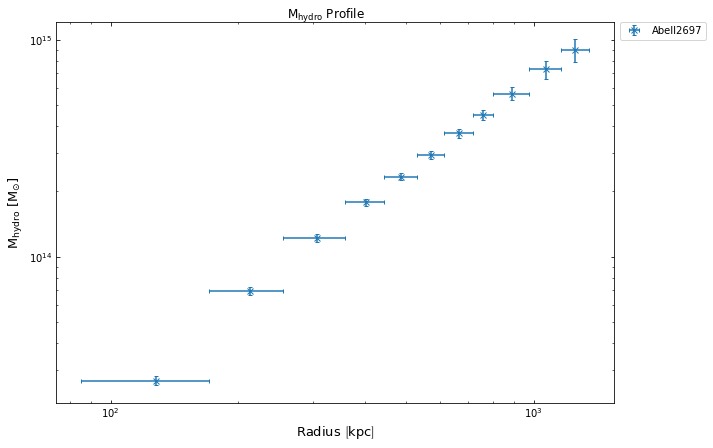

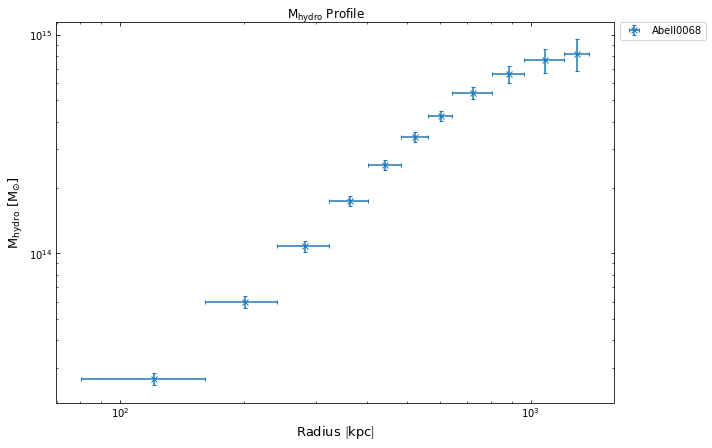

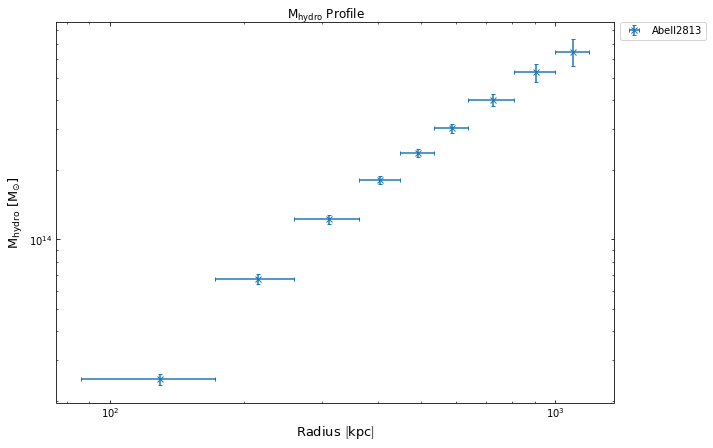

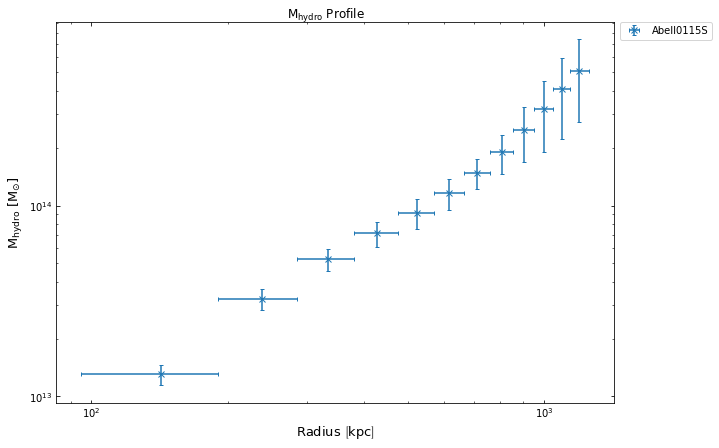

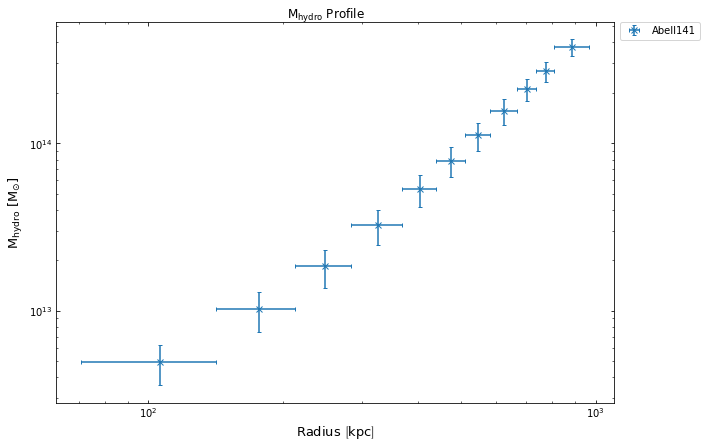

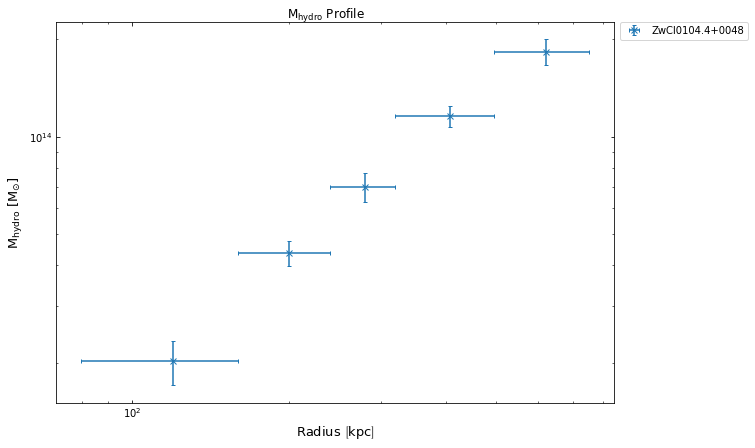

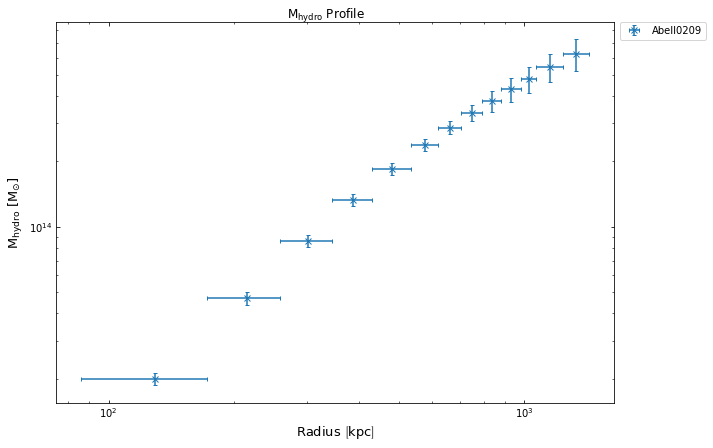

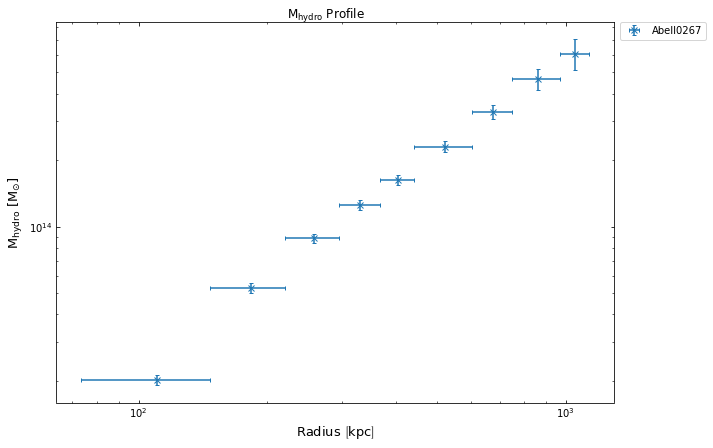

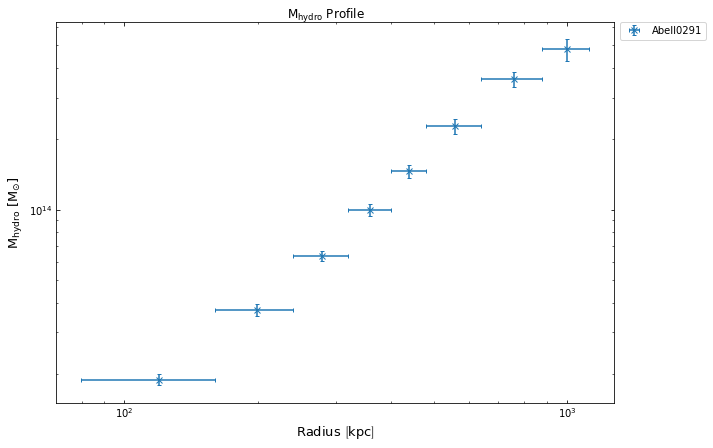

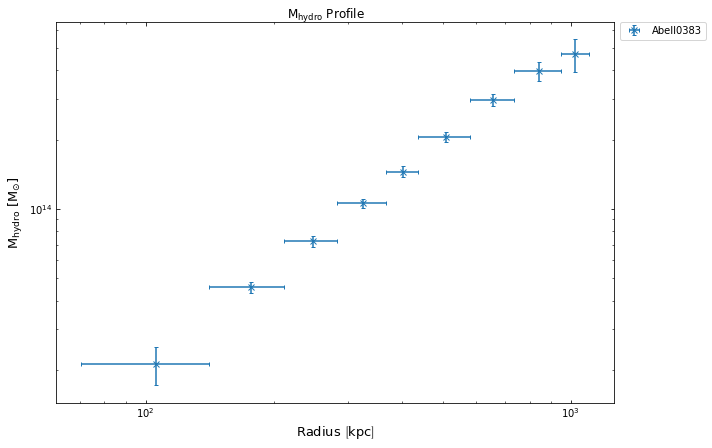

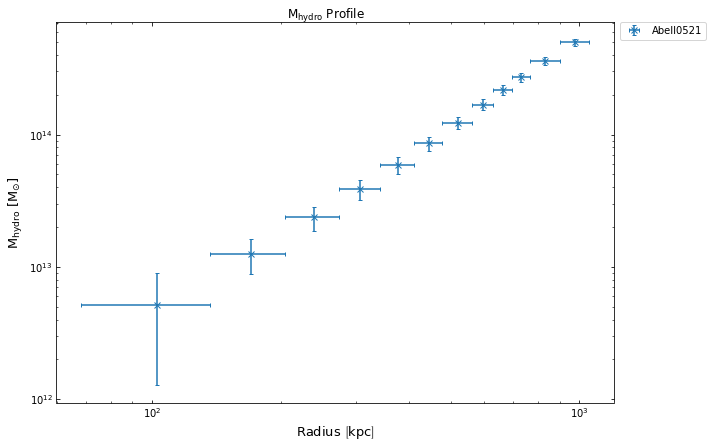

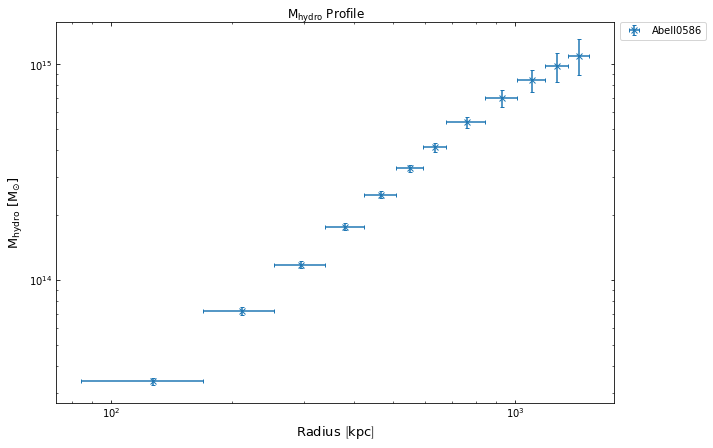

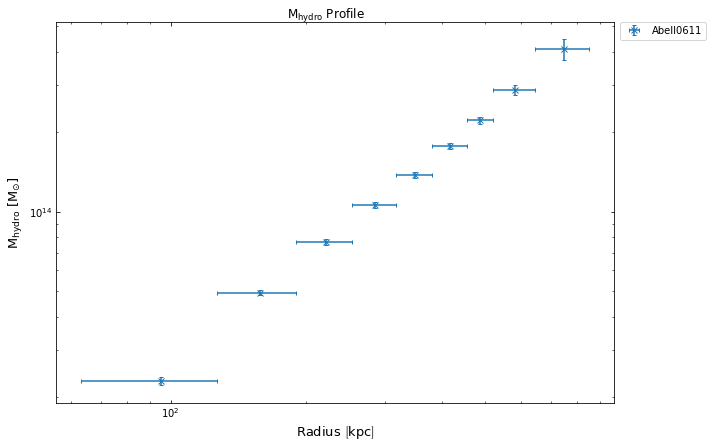

AttributeError: 'NoneType' object has no attribute 'view'

In [58]:
for mp in loc_sb_dblbeta_simpvikh_105_mp:
    mp.view()

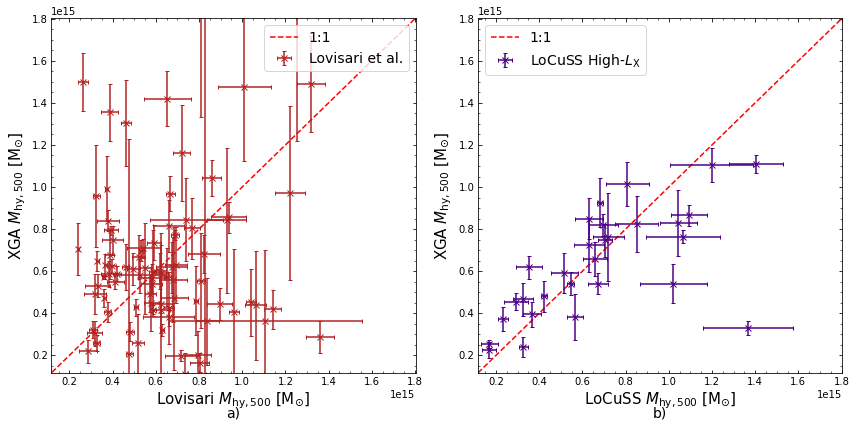

In [51]:
# Setting the y-position and font size of the a and b labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of mass measurements
lov_lims = find_lims(lov_lit_ms, lov_sb_dblbeta_simpvikh_105_m500).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_ms[:, 0].value, lov_sb_dblbeta_simpvikh_105_m500[:, 0].value, 
             xerr=lov_lit_ms[:, 1].value, 
             yerr=lov_sb_dblbeta_simpvikh_105_m500[:, 1].T.value, fmt='x', 
             color=lov_colour, capsize=2, label=r"Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari $M_{\rm{hy, 500}}$ [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel(r"XGA $M_{\rm{hy,500}}$ [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of mass measurements
loc_lims = find_lims(loc_lit_ms, loc_sb_dblbeta_simpvikh_105_m500).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_ms[:, 0].value, loc_sb_dblbeta_simpvikh_105_m500[:, 0].value, 
             xerr=loc_lit_ms[:, 1].value, 
             yerr=loc_sb_dblbeta_simpvikh_105_m500[:, 1].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel(r"XGA $M_{\rm{hy,500}}$ [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/lov_loc_sb_dblbeta_svikh_1.05r500_hym500_comp.pdf")
plt.show()